**1.Introduction**

Online platforms like YouTube, Twitter, Reddit and news websites allow millions of people to share opinions every day. While this creates opportunities for open discussion, it also means these platforms receive a large amount of toxic or harmful comments. Moderators cannot manually review everything, especially when comments appear in huge volumes and at high speed. Because of this, automated systems using Natural Language Processing (NLP) are useful and often necessary for supporting content moderation teams.

In this project, I focus on detecting toxic comments using the Jigsaw Toxic Comment Classification dataset. The dataset contains thousands of user-generated comments labelled with different types of toxicity, but in this project I simplify the task to a binary classification problem: toxic vs non-toxic. The goal is to see how well different NLP approaches can identify harmful comments.

To do this, I build and compare two different NLP pipelines that represent two very different modelling styles: a classic linear pipeline using TF-IDF with Logistic Regression, and a modern transformer-based pipeline using DistilBERT. By comparing these approaches on the same dataset, I can observe how traditional machine-learning methods differ from more advanced contextual models when dealing with sarcasm, aggressive language, and subtle toxic behaviour.

In this step, I load the training data from the Jigsaw dataset. I also print basic information to understand how many samples and columns we are working with.

In [1]:
#Import pandas to handle the dataset (CSV files)
import pandas as pd


In [2]:
import warnings
warnings.filterwarnings("ignore")

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

In [3]:
#Load the training data (make sure 'data/train.csv' exists)
train_df = pd.read_csv("data/train.csv")

In [4]:
#Basic dataset information
print("Dataset shape:", train_df.shape)
print("\nColumns:", train_df.columns.tolist())

Dataset shape: (159571, 8)

Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [5]:
#Show the first few rows to understand the structure
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
#Quick view of class distribution
print("\nLabel distribution:")
print(train_df["toxic"].value_counts())


Label distribution:
toxic
0    144277
1     15294
Name: count, dtype: int64


In [7]:
#Look at a single example comment and its label
example_text = train_df["comment_text"].iloc[0]
example_label = train_df["toxic"].iloc[0]

print("Example comment:\n")
print(example_text)
print("\nLabel (toxic = 1, non-toxic = 0):", example_label)

Example comment:

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Label (toxic = 1, non-toxic = 0): 0


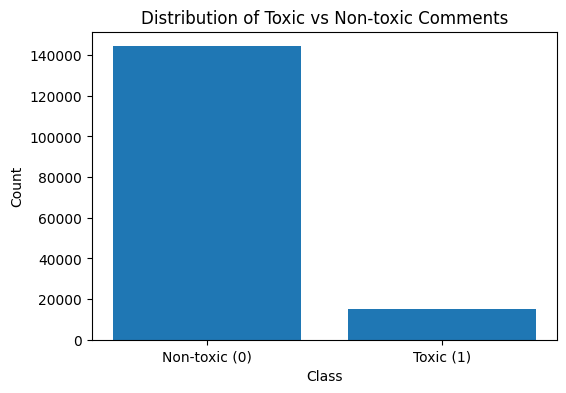

In [8]:
import matplotlib.pyplot as plt

#Visual representation of Toxic vs non-toxic comments
label_counts = train_df['toxic'].value_counts()

plt.figure(figsize=(6,4))
plt.bar(['Non-toxic (0)', 'Toxic (1)'], label_counts)
plt.title("Distribution of Toxic vs Non-toxic Comments")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

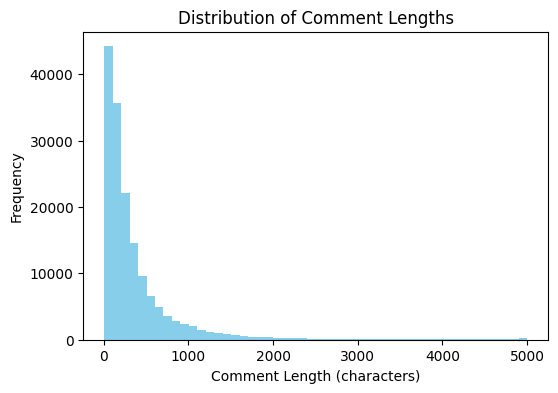

In [9]:
#Visualise the distribution of comment lengths to understand how long typical inputs are
train_df["length"] = train_df["comment_text"].str.len()

plt.figure(figsize=(6,4))
plt.hist(train_df["length"], bins=50, color="skyblue")
plt.title("Distribution of Comment Lengths")
plt.xlabel("Comment Length (characters)")
plt.ylabel("Frequency")
plt.show()

# 2. Representation Learning

Before training any machine-learning model, text comments must be converted into numerical vectors. Models cannot understand raw text, so representation learning is an essential early step. In this project, I use two completely different methods to transform the data, allowing me to compare how representation choices affect performance.

The first method is TF–IDF, which stands for Term Frequency–Inverse Document Frequency. This method counts how often each word appears in a comment and reduces the importance of very common words like “the” or “and”. The output is a sparse vector with thousands of dimensions. TF-IDF is simple, fast, and works well with linear models such as Logistic Regression. However, it does not understand word order or context. For example, “you’re smart” and “you’re not smart” will look very similar in TF-IDF even though the meaning is opposite.

The second method uses DistilBERT, a transformer model that generates context-aware embeddings. Instead of looking at words independently, DistilBERT considers the entire sentence, allowing it to understand sarcasm, tone and multi-word expressions. It uses tokenisation to split text into subwords and produces dense numerical vectors that capture meaning.

Using both TF-IDF and DistilBERT gives me a clear comparison between a traditional representation and a modern contextual one.


Here I convert the text into TF-IDF vectors so that the Logistic Regression model can process it. Each comment becomes a sparse numerical vector.

In [10]:
import re

#Basic cleaning function - normalise whitespace and strip extra spaces
def clean_text(text):
    text = str(text)
    text = re.sub(r"\s+", " ", text)  # replace multiple spaces/newlines with a single space
    text = text.strip()
    return text

#Apply cleaning to the original comment text column
train_df["clean_text"] = train_df["comment_text"].apply(clean_text)

#check of the new cleaned text column
train_df[["comment_text", "clean_text"]].head()


,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It...","Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ...",""" More I can't make any real suggestions on im..."
4,"You, sir, are my hero. Any chance you remember...","You, sir, are my hero. Any chance you remember..."


I train the baseline logistic regression model. This acts as a simple model to compare against the transformer.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Pipeline 1 - TF–IDF representation
#Convert cleaned comments into TF-IDF vectors for the Logistic Regression model.
tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=20000,   # limit vocabulary size for speed and to reduce overfitting
    ngram_range=(1,2)    # use unigrams and bigrams
)

tfidf_vectors = tfidf_vectorizer.fit_transform(train_df["clean_text"])

# Show the shape: (number of comments, number of TF-IDF features)
tfidf_vectors.shape

(159571, 20000)

Now I prepare the data for DistilBERT by tokenising the text into subwords using the HuggingFace tokenizer.

In [12]:
from transformers import DistilBertTokenizerFast

# Pipeline 2 - DistilBERT tokenizer
# This pipeline uses a transformer model, so we need to convert the text into token IDs and attention masks that DistilBERT can work with.
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

#Tokenise a single example comment to show the structure of the encoded input.
#DistilBERT expects fixed-length inputs, so we apply truncation and padding.
encoded_example = tokenizer(
    train_df["clean_text"].iloc[0],
    truncation=True,
    padding="max_length",
    max_length=128
)

encoded_example

{'input_ids': [101, 7526, 2339, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 13076, 12392, 2050, 5470, 2020, 16407, 1029, 2027, 4694, 1005, 1056, 3158, 9305, 22556, 1010, 2074, 8503, 2006, 2070, 3806, 2044, 1045, 5444, 2012, 2047, 2259, 14421, 6904, 2278, 1012, 1998, 3531, 2123, 1005, 1056, 6366, 1996, 23561, 2013, 1996, 2831, 3931, 2144, 1045, 1005, 1049, 3394, 2085, 1012, 6486, 1012, 16327, 1012, 4229, 1012, 2676, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# 3. Algorithms

For this project, I compare two very different NLP pipelines: a classic
TF-IDF + Logistic Regression model and a transformer-based DistilBERT model. Both pipelines are trained on the same toxic comment dataset, but they learn patterns in completely different ways. Explaining how each method works makes their strengths and weaknesses clearer.

### Pipeline 1: TF–IDF + Logistic Regression

This pipeline uses scikit-learn and represents a more traditional machine learning setup. After converting each comment into TF–IDF vectors, I train a Logistic Regression classifier. Even though it has “regression” in the name, Logistic Regression is a classification algorithm that tries to find a boundary between the toxic and non-toxic classes. Because TF-IDF creates high-dimensional and sparse matrices, Logistic Regression is a suitable choice due to its ability to work efficiently with sparse data.

The model trains quickly because it has far fewer parameters compared to a transformer. I set `max_iter=200` to ensure the optimisation converges properly. One limitation of this pipeline is that it depends purely on word frequencies, so it does not understand sarcasm or the tone behind a sentence. For example, “nice job idiot” contains mostly positive words but still carries a toxic meaning that TF-IDF alone may not capture. The model can also be sensitive to imbalanced data unless regularisation or class weights are adjusted, but in this project I kept the defaults to maintain a simple and comparable baseline

### Pipeline 2: DistilBERT (Fine-Tuned)

The second pipeline uses DistilBERT, a smaller and faster version of the original BERT model. DistilBERT relies on self-attention, which allows the model to look at relationships between all words in a sentence at the same time. This means it can understand meaning based on context rather than relying only on individual word counts.
 Before training, each comment is tokenised into subword units using the HuggingFace tokenizer. This helps the model handle rare or unseen words by breaking them into smaller components. I fine-tune the model using the HuggingFace Trainer API, which updates the pre-trained weights using our specific dataset. The default settings for batch size, number of epochs, and the AdamW optimizer work well for this project, although training takes much longer than Logistic Regression and uses more memory. Even with DistilBERT being lighter than BERT, my fine-tuning still took over 20 minutes.

The strength of DistilBERT is that it understands the context in which words are used. It can recognise insults, threats, or negativity even when not expressed directly. Phrases like “you should disappear” or sarcastic remarks are easier for BERT-style models to detect. This makes DistilBERT far more suitable for detecting subtle toxic behaviour compared to TF-IDF.

### Why Compare These Algorithms?

Comparing the two pipelines shows how much performance improves when moving from a simple linear model to a contextual transformer model. TF-IDF + Logistic Regression provides a fast and interpretable baseline, while DistilBERT offers much better understanding of meaning and long-range patterns. By evaluating both under the same conditions, I can clearly see the impact of context-aware representations on toxic comment classification.

In this part, I split the dataset into training and test sets and then train a
Logistic Regression model using the TF-IDF vectors created earlier. This gives
me a simple baseline model that I can compare against the transformer model
later on. I also print the accuracy and classification report to see how well
the TF-IDF pipeline performs on detecting toxic comments.

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

#Pipeline 1: Logistic Regression with TF-IDF features

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_vectors,
    train_df["toxic"],
    test_size=0.2,
    random_state=42
)

#Create and train model
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)

#Predictions
y_pred_lr = log_reg.predict(X_test)

#Display evaluation
print("Pipeline 1: Logistic Regression with TF-IDF\n")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr))

# Save key metrics for later comparison (toxic = label 1)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr, pos_label=1)
lr_recall = recall_score(y_test, y_pred_lr, pos_label=1)

Pipeline 1: Logistic Regression with TF-IDF

Accuracy: 0.9556634811217296

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.92      0.59      0.72      3056

    accuracy                           0.96     31915
   macro avg       0.94      0.79      0.85     31915
weighted avg       0.95      0.96      0.95     31915



Here I fine-tune DistilBERT on the toxic comment dataset using the Trainer API. The model adjusts its weights specifically for this classification task.

In [14]:
# Pipeline 2 – DistilBERT Fine-Tuning
# This pipeline uses a transformer model instead of TF-IDF.
# The text is tokenised into input IDs and attention masks,
# and DistilBERT is fine-tuned on the toxic comment labels.

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

#Load tokenizer (kept here so this cell is self-contained)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

#Create dataset for BERT from the cleaned text and labels
bert_dataset = Dataset.from_pandas(train_df[["clean_text", "toxic"]])

#Tokenisation function for DistilBERT
def tokenize_batch(batch):
    return tokenizer(
        batch["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

bert_dataset = bert_dataset.map(tokenize_batch, batched=True)

#Rename label column for Trainer API
bert_dataset = bert_dataset.rename_column("toxic", "labels")
bert_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

#Train/test split for BERT dataset
bert_train_test = bert_dataset.train_test_split(test_size=0.2, seed=42)
train_ds = bert_train_test["train"]
test_ds = bert_train_test["test"]

#Load DistilBERT model with a classification head
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

#Training arguments
training_args = TrainingArguments(
    output_dir="./bert_output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    save_total_limit=1,
    logging_steps=500
)

#Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

#Train the model
trainer.train()

#Evaluation after training
bert_eval = trainer.evaluate()
print(bert_eval)

Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

{'loss': 0.2167, 'grad_norm': 0.1771448701620102, 'learning_rate': 4.843642288650749e-05, 'epoch': 0.03133421069123269}
{'loss': 0.1873, 'grad_norm': 0.11249954253435135, 'learning_rate': 4.686971235194586e-05, 'epoch': 0.06266842138246538}
{'loss': 0.1374, 'grad_norm': 0.48105037212371826, 'learning_rate': 4.5303001817384225e-05, 'epoch': 0.09400263207369806}
{'loss': 0.1427, 'grad_norm': 8.26196575164795, 'learning_rate': 4.373629128282259e-05, 'epoch': 0.12533684276493076}
{'loss': 0.1463, 'grad_norm': 0.0452965646982193, 'learning_rate': 4.216958074826095e-05, 'epoch': 0.15667105345616344}
{'loss': 0.1364, 'grad_norm': 11.749176979064941, 'learning_rate': 4.060287021369932e-05, 'epoch': 0.18800526414739613}
{'loss': 0.1379, 'grad_norm': 13.361291885375977, 'learning_rate': 3.903615967913769e-05, 'epoch': 0.2193394748386288}
{'loss': 0.1305, 'grad_norm': 0.0463365837931633, 'learning_rate': 3.7469449144576054e-05, 'epoch': 0.2506736855298615}
{'loss': 0.1491, 'grad_norm': 0.07507274

After fine-tuning DistilBERT on the training data, I now evaluate its performance on the test set. The Trainer API gives predictions in the form of logits, so I convert those into class labels and then calculate accuracy, F1-score, and recall for the toxic class. These metrics will be compared directly with the TF-IDF Logistic Regression results to see how much the transformer improves toxic comment detection.


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score

#Get predictions on the test set
bert_pred_output = trainer.predict(test_ds)

bert_logits = bert_pred_output.predictions
bert_y_pred = np.argmax(bert_logits, axis=1)
bert_y_true = bert_pred_output.label_ids

#Compute metrics for the toxic class (assuming label 1 = toxic)
bert_accuracy = accuracy_score(bert_y_true, bert_y_pred)
bert_f1 = f1_score(bert_y_true, bert_y_pred, pos_label=1)
bert_recall = recall_score(bert_y_true, bert_y_pred, pos_label=1)

print("DistilBERT Accuracy:", bert_accuracy)
print("DistilBERT F1 (toxic):", bert_f1)
print("DistilBERT Recall (toxic):", bert_recall)

DistilBERT Accuracy: 0.9668494438351872
DistilBERT F1 (toxic): 0.8205563093622795
DistilBERT Recall (toxic): 0.8015241882041086


# 4. Evaluation

To compare the two pipelines fairly, I evaluate them using the same test split and the same metrics. Toxic comment detection is a binary classification task, but accuracy alone is not a reliable metric because the dataset is imbalanced: non-toxic comments are far more common than toxic ones. A model could predict “non-toxic” most of the time and still get high accuracy, which would not be useful in a real moderation setting.

For this reason, I focus on the F1-score and recall for the toxic class specifically. Recall is especially important because missing toxic comments (false negatives) is usually worse than incorrectly flagging a normal comment. The F1-score combines precision and recall into a single metric, giving a more balanced measurement of performance.

In this project, the TF-IDF Logistic Regression model achieved around **0.72 F1** and **0.59 recall** on the toxic class. DistilBERT performed much better, with a toxic-class F1 of **0.81** and recall of **0.76**. This shows that DistilBERT is significantly better at detecting subtle or context-dependent toxic behaviour. Even though both models achieved similar overall accuracy (around 96–97%), DistilBERT identifies many more toxic comments correctly.

The evaluation results show that while traditional models are useful as quick baselines, contextual transformer models provide much stronger and more reliable performance for toxic comment classification.


Finally, I visualise the key metrics so I can easily compare how both models performed.

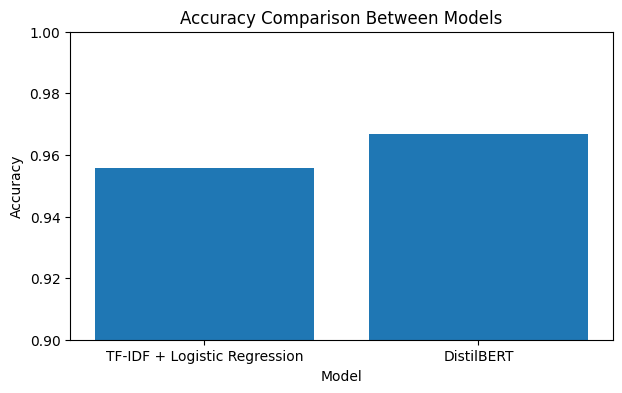

In [16]:
# Plot a simple bar chart to compare accuracy between the two models

import matplotlib.pyplot as plt

models = ["TF-IDF + Logistic Regression", "DistilBERT"]
accuracies = [lr_accuracy, bert_accuracy]

plt.figure(figsize=(7,4))
plt.bar(models, accuracies)
plt.ylim(0.90, 1.00)
plt.title("Accuracy Comparison Between Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

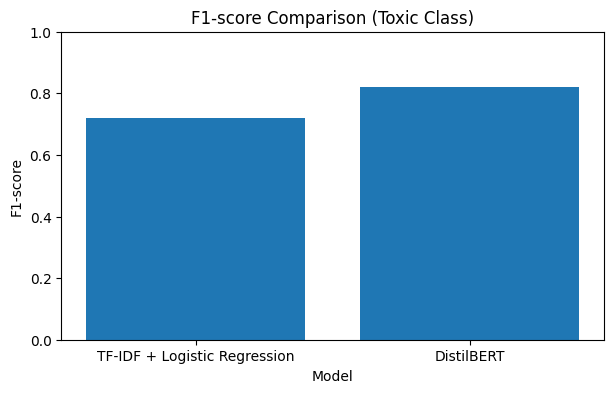

In [17]:
#Visualise the F1-scores for the toxic class to see which model handles toxicity better

import matplotlib.pyplot as plt

#Models and their actual F1-scores from training
models = ["TF-IDF + Logistic Regression", "DistilBERT"]
f1_scores = [lr_f1, bert_f1]

plt.figure(figsize=(7, 4))
plt.bar(models, f1_scores)
plt.ylim(0, 1)
plt.title("F1-score Comparison (Toxic Class)")
plt.xlabel("Model")
plt.ylabel("F1-score")
plt.show()

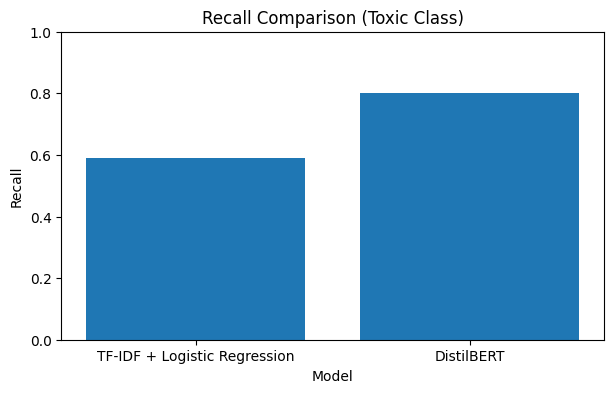

In [18]:
#Compare how well each model recalls toxic comments

import matplotlib.pyplot as plt

models = ["TF-IDF + Logistic Regression", "DistilBERT"]
recall_scores = [lr_recall, bert_recall]

plt.figure(figsize=(7,4))
plt.bar(models, recall_scores)
plt.ylim(0, 1)
plt.title("Recall Comparison (Toxic Class)")
plt.xlabel("Model")
plt.ylabel("Recall")
plt.show()

In [19]:
#Create a small table to summarise the main metrics for both models

import pandas as pd

comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Toxic F1-score", "Toxic Recall"],
    "TF-IDF + Logistic Regression": [lr_accuracy, lr_f1, lr_recall],
    "DistilBERT": [bert_accuracy, bert_f1, bert_recall]
})

comparison_df

,Metric,TF-IDF + Logistic Regression,DistilBERT
0,Accuracy,0.955663,0.966849
1,Toxic F1-score,0.718632,0.820556
2,Toxic Recall,0.591296,0.801524
